In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

## Overview of the Data
We'll begin by getting a sense of what the data looks like.

In [2]:
%%sql
SELECT *
  FROM facts
 LIMIT 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:

- name - The name of the country.
- area - The total land and sea area of the country.
- population - The country's population.
- population_growth- The country's population growth as a percentage.
- birth_rate - The country's birth rate, or the number of births a year per 1,000 people.
- death_rate - The country's death rate, or the number of death a year per 1,000 people.
- area- The country's total area (both land and water).
- area_land - The country's land area in square kilometers.
- area_water - The country's waterarea in square kilometers.

Let's start by calculating some summary statistics and see what they tell us.

In [3]:
%%sql
SELECT MIN(population) AS min_pop,
       MAX(population) AS max_pop,
       MIN(population_growth) AS min_pop_growth,
       MAX(population_growth) AS max_pop_growth
  FROM facts;

 * sqlite:///factbook.db
Done.


min_pop,max_pop,min_pop_growth,max_pop_growth
0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last screen:

- There's a country with a population of 0
- There's a country with a population of 7256490011 (or more than 7.2 billion people)

Let's use subqueries to zoom in on just these countries without using the specific values.

## Exploring Outliers

In [5]:
%%sql
SELECT *
  FROM facts 
 WHERE population == (SELECT MIN(population)
                        FROM facts
                     );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


It seems like the table contains a row for Antarctica, which explains the population of 0. This seems to match the CIA Factbook [page for Antarctica](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html):

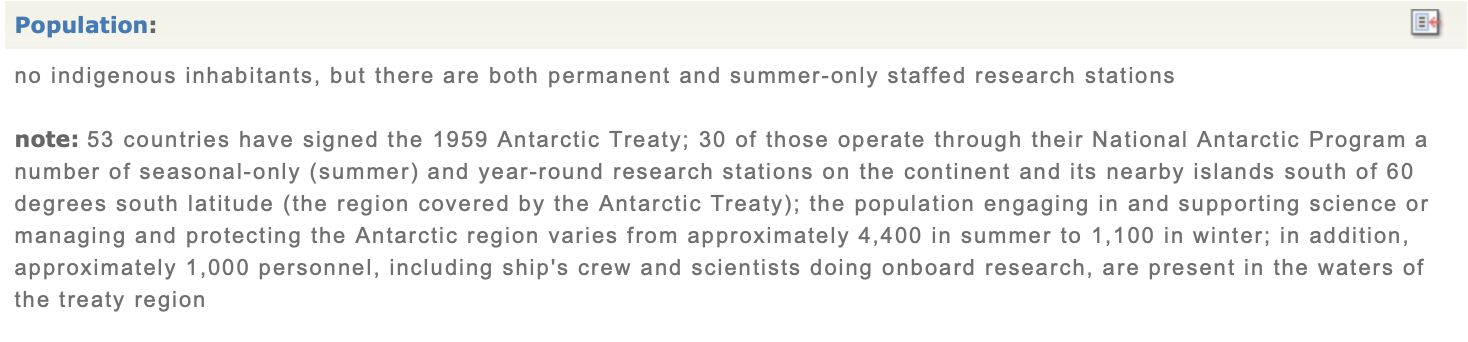

In [6]:
%%sql
SELECT *
  FROM facts
 WHERE population == (SELECT MAX(population)
                        FROM facts
                     );

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


We also see that the table contains a row for the whole world, which explains the maximum population of over 7.2 billion we found earlier.

Now that we know this, we should recalculate the summary statistics we calculated earlier, while excluding the row for the whole world.

## Summary Statistics Revisited

In [10]:
%%sql
SELECT MIN(population) AS min_pop,
       MAX(population) AS max_pop,
       MIN(population_growth) AS min_pop_growth,
       MAX(population_growth) AS max_pop_growth 
  FROM facts
 WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


min_pop,max_pop,min_pop_growth,max_pop_growth
0,1367485388,0.0,4.02


There's a country whose population closes in on 1.4 billion!

In [11]:
%%sql
SELECT ROUND(AVG(population), 2) AS avg_population,
       ROUND(AVG(area), 2) AS avg_area
  FROM facts
 WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


avg_population,avg_area
32242666.57,555093.55


We see that the average population is around 32 million and the average area is 555 thousand square kilometers.

## Finding Densely Populated Countries

To finish, we'll build on the query above to find countries that are densely populated. We'll identify countries that have:

- Above average values for population.
- Below average values for area.

In [12]:
%%sql
SELECT *
  FROM facts
 WHERE population > (SELECT AVG(population)
                       FROM facts
                      WHERE name <> 'World'
                    )
   AND area < (SELECT AVG(area)
                 FROM facts
                WHERE name <> 'World'
);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
80,iz,Iraq,438317,437367,950,37056169,2.93,31.45,3.77,1.62
83,it,Italy,301340,294140,7200,61855120,0.27,8.74,10.19,4.1
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
91,ks,"Korea, South",99720,96920,2800,49115196,0.14,8.19,6.75,0.0
120,mo,Morocco,446550,446300,250,33322699,1.0,18.2,4.81,3.36
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
139,pl,Poland,312685,304255,8430,38562189,0.09,9.74,10.19,0.46
163,sp,Spain,505370,498980,6390,48146134,0.89,9.64,9.04,8.31


Some of these countries are generally known to be densely populated, so we have confidence in our results!

What countries have the highest population/area ratio and how does it compare to list we found in the previous screen? We will narrow this down to populations that are larger than the world average to see the most crowded populated countries.  

In [17]:
%%sql
SELECT name, area, population, 
       ROUND(population/area, 2) AS pop_area_ratio
  FROM facts
 WHERE population > (SELECT AVG(population)
                       FROM facts
                      WHERE name <> 'World'
                    )

 ORDER BY pop_area_ratio DESC
 LIMIT 20;  


 * sqlite:///factbook.db
Done.


name,area,population,pop_area_ratio
Bangladesh,148460,168957745,1138.0
"Korea, South",99720,49115196,492.0
India,3287263,1251695584,380.0
Philippines,300000,100998376,336.0
Japan,377915,126919659,335.0
Vietnam,331210,94348835,284.0
United Kingdom,243610,64088222,263.0
Pakistan,796095,199085847,250.0
Germany,357022,80854408,226.0
Italy,301340,61855120,205.0
